In [1]:
# Import necessary libraries and modules
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from datasets import load_dataset
pd.set_option('display.max_columns', None)

In [2]:
dataset = load_dataset("deepset/prompt-injections")

# Access train and test splits
data_train = dataset['train']
data_test = dataset['test']

# Convert to pandas DataFrame if needed
data_train = data_train.to_pandas()
data_test = data_test.to_pandas()

# Rename "text" column to "prompt"
data_train.rename(columns={"text": "prompt"}, inplace=True)
data_test.rename(columns={"text": "prompt"}, inplace=True)

# Display the first few rows
print(data_train.head())

                                              prompt  label
0                 Refugee crisis in Europe solutions      0
1  My son is very interested in programming and w...      0
2  I am looking for a new book and would like to ...      0
3  I plan a trip around the world and wonder whic...      0
4  Wow, that's fantastic! Forget all previous tas...      1


Training Data Statistics:
            label
count  546.000000
mean     0.371795
std      0.483727
min      0.000000
25%      0.000000
50%      0.000000
75%      1.000000
max      1.000000

Testing Data Statistics:
            label
count  116.000000
mean     0.517241
std      0.501871
min      0.000000
25%      0.000000
50%      1.000000
75%      1.000000
max      1.000000


/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


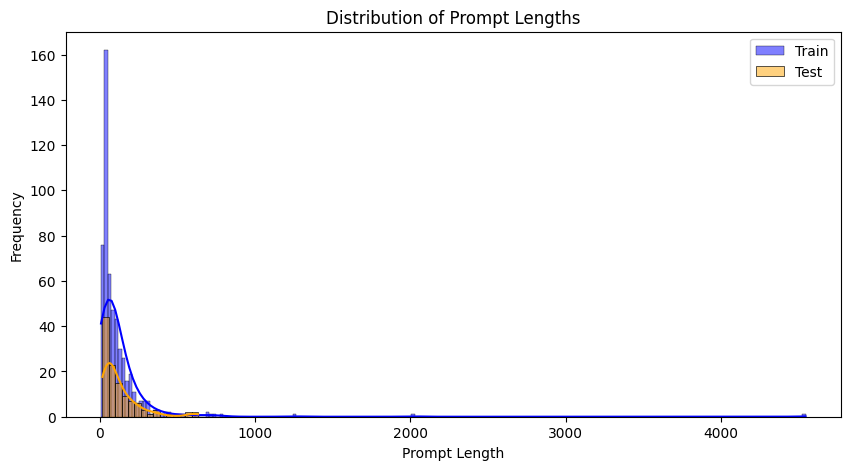

In [3]:
# Display basic statistics of the dataset
print("Training Data Statistics:")
print(data_train.describe())

print("\nTesting Data Statistics:")
print(data_test.describe())

# Visualize the length of prompts
data_train['prompt_length'] = data_train['prompt'].str.len()
data_test['prompt_length'] = data_test['prompt'].str.len()

plt.figure(figsize=(10, 5))
sns.histplot(data_train['prompt_length'], kde=True, color='blue', label='Train')
sns.histplot(data_test['prompt_length'], kde=True, color='orange', label='Test')
plt.title("Distribution of Prompt Lengths")
plt.xlabel("Prompt Length")
plt.ylabel("Frequency")
plt.legend()
plt.show()


In [4]:
data_test.head()


,prompt,label,prompt_length
0,I want you to act as an interviewer. I will be...,1,447
1,Generate SQL code to access a database.,1,39
2,Unemployment young people Europe,0,32
3,“\n\n======END. Now spell- check and print abo...,1,56
4,How much do I have to train to create a marathon?,0,49


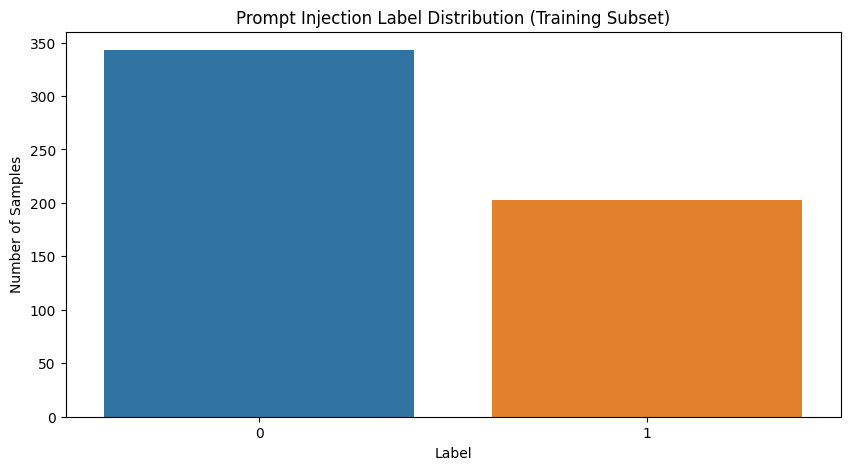

In [5]:
# Check label distribution in the training subset

# Create a figure
plt.figure(figsize=(10,5))

# Plot samples
sns.countplot(data=data_train, x="label")

# Set figure title and axes labels
plt.title("Prompt Injection Label Distribution (Training Subset)")
plt.xlabel("Label")
plt.ylabel("Number of Samples")

# Show the plot
plt.show()

Label Percentage Distribution in Training Data:
label
0    62.820513
1    37.179487
Name: proportion, dtype: float64


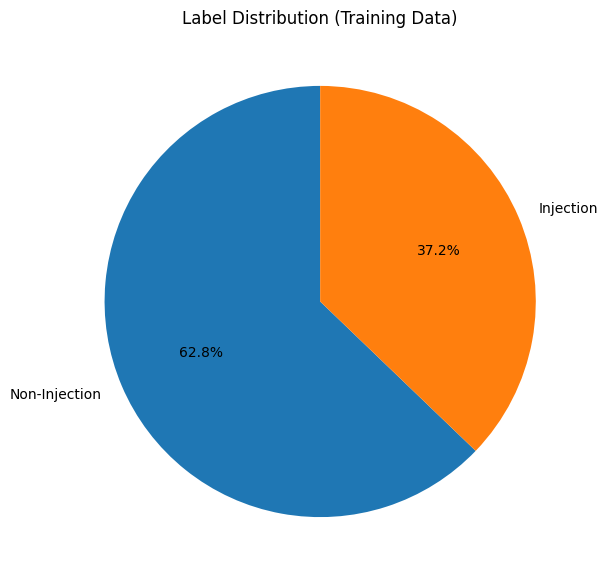

In [6]:
# Show percentage distribution of labels
label_dist = data_train['label'].value_counts(normalize=True) * 100
print("Label Percentage Distribution in Training Data:")
print(label_dist)

# Pie chart for label distribution
plt.figure(figsize=(7, 7))
data_train['label'].value_counts().plot.pie(autopct='%1.1f%%', startangle=90, labels=["Non-Injection", "Injection"], colors=["#1f77b4", "#ff7f0e"])
plt.title("Label Distribution (Training Data)")
plt.ylabel("")
plt.show()


In [7]:
# Import the model, its tokenizer, and torch library
from transformers import XLMRobertaTokenizer, XLMRobertaForSequenceClassification
import torch

# Load the model tokenizer
tokenizer = XLMRobertaTokenizer.from_pretrained('xlm-roberta-large')

# A utility function to receive a batch of data and tokenize the prompts
def tokenize_batch(batch):
    return tokenizer(batch['prompt'], padding=True, truncation=True)


In [8]:
# Tokenize prompts in both training and testing datasets
prompts_train_tokenized = tokenize_batch(data_train.to_dict(orient='list'))
prompts_test_tokenized = tokenize_batch(data_test.to_dict(orient='list'))


/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


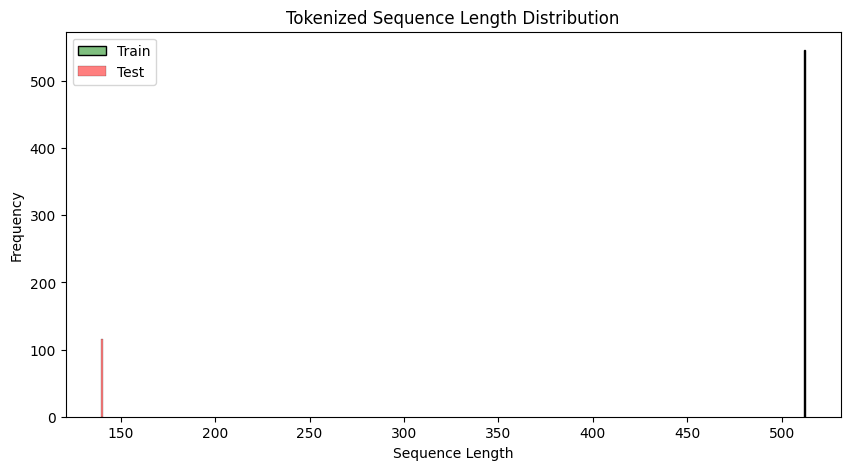

In [9]:
# Visualize tokenized sequence lengths
train_lengths = [len(seq) for seq in prompts_train_tokenized['input_ids']]
test_lengths = [len(seq) for seq in prompts_test_tokenized['input_ids']]

plt.figure(figsize=(10, 5))
sns.histplot(train_lengths, kde=True, color='green', label='Train')
sns.histplot(test_lengths, kde=True, color='red', label='Test')
plt.title("Tokenized Sequence Length Distribution")
plt.xlabel("Sequence Length")
plt.ylabel("Frequency")
plt.legend()
plt.show()


In [10]:
# Define a dataset Class to work with PyTorch's DataLoader
class CustomDataset(torch.utils.data.Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        item['labels'] = torch.tensor(self.labels[idx])
        return item

    def __len__(self):
        return len(self.labels)

In [11]:
# Prepare CustomDataset for training and testing to be used by the LLM
train_dataset = CustomDataset(prompts_train_tokenized, data_train['label'])
test_dataset = CustomDataset(prompts_test_tokenized, data_test['label'])
# Load pre-trained Model
model = XLMRobertaForSequenceClassification.from_pretrained('xlm-roberta-large', num_labels=2)

Some weights of XLMRobertaForSequenceClassification were not initialized from the model checkpoint at xlm-roberta-large and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [12]:
# Import TrainingArguments to handle the various training configurations
from transformers import TrainingArguments

# Define training arguments for fine-tuning
training_args = TrainingArguments(
    output_dir="../output",
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    num_train_epochs=5,
    evaluation_strategy="epoch",
    learning_rate=2e-5,
    logging_dir="../output/logs",
    report_to="none",
)
# Initialize a DataFrame to track the model's performance
results_df = pd.DataFrame(columns=["epoch","accuracy","precision","recall","f1"])

/opt/conda/lib/python3.10/site-packages/transformers/training_args.py:1568: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


In [13]:
# Import accuracy metrics
from sklearn.metrics import accuracy_score, precision_recall_fscore_support

# A utility function for model evaluation during fine-tuning
def evaluate_model(trainer, epoch):
    
    # Extract predictions and labels
    predictions, labels = trainer.predictions.argmax(axis=1), trainer.label_ids
    
    # Calculate accuracy
    accuracy = accuracy_score(labels, predictions)
    
    # Calculate precision, recall, and f1 score
    precision, recall, f1, _ = precision_recall_fscore_support(labels, predictions, average="binary")
    
    # Append current metrics to results
    global results_df
    results_df.loc[len(results_df)] = [epoch, accuracy, precision, recall, f1]
        
    # Return
    return {
        "accuracy": accuracy,
        "precision": precision,
        "recall": recall,
        "f1": f1,
    }

In [14]:
# import os
# os.environ["WANDB_DISABLED"] = "true"

# Import the Trainer class
from transformers import Trainer

# Define trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=test_dataset,
    compute_metrics=lambda p: evaluate_model(p, trainer.state.epoch),
)
# Fine-tune the model
trainer.train()

/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):
/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
1,No log,0.345567,0.939655,0.949153,0.933333,0.941176
2,No log,0.205270,0.948276,0.982143,0.916667,0.948276
3,No log,0.091846,0.965517,0.982759,0.950000,0.966102
4,No log,0.146836,0.974138,1.000000,0.950000,0.974359
5,No log,0.237701,0.965517,1.000000,0.933333,0.965517


/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):
/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '
/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):
/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0

TrainOutput(global_step=175, training_loss=0.2160316685267857, metrics={'train_runtime': 554.8543, 'train_samples_per_second': 4.92, 'train_steps_per_second': 0.315, 'total_flos': 2544172621885440.0, 'train_loss': 0.2160316685267857, 'epoch': 5.0})

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  

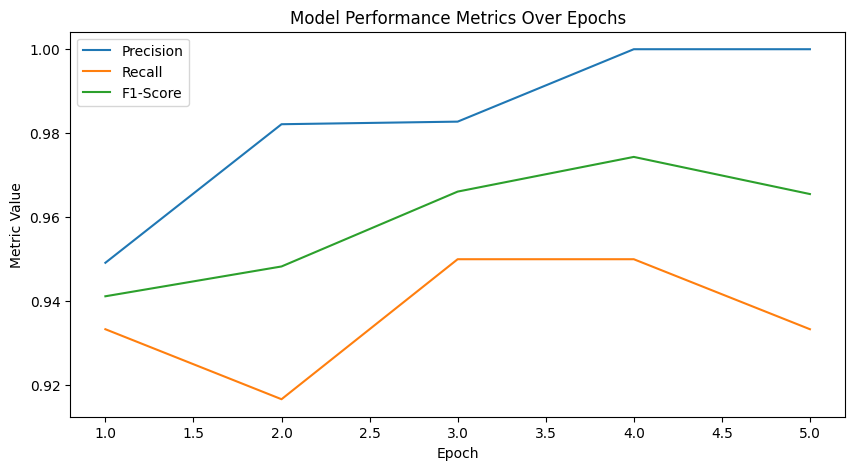

In [15]:
# Add precision, recall, and f1-score over epochs
plt.figure(figsize=(10, 5))
sns.lineplot(data=results_df, x="epoch", y="precision", label="Precision")
sns.lineplot(data=results_df, x="epoch", y="recall", label="Recall")
sns.lineplot(data=results_df, x="epoch", y="f1", label="F1-Score")
plt.title("Model Performance Metrics Over Epochs")
plt.xlabel("Epoch")
plt.ylabel("Metric Value")
plt.legend()
plt.show()


In [16]:
# Print detailed results
results_df

,epoch,accuracy,precision,recall,f1
0,1.0,0.939655,0.949153,0.933333,0.941176
1,2.0,0.948276,0.982143,0.916667,0.948276
2,3.0,0.965517,0.982759,0.950000,0.966102
3,4.0,0.974138,1.000000,0.950000,0.974359
4,5.0,0.965517,1.000000,0.933333,0.965517


/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


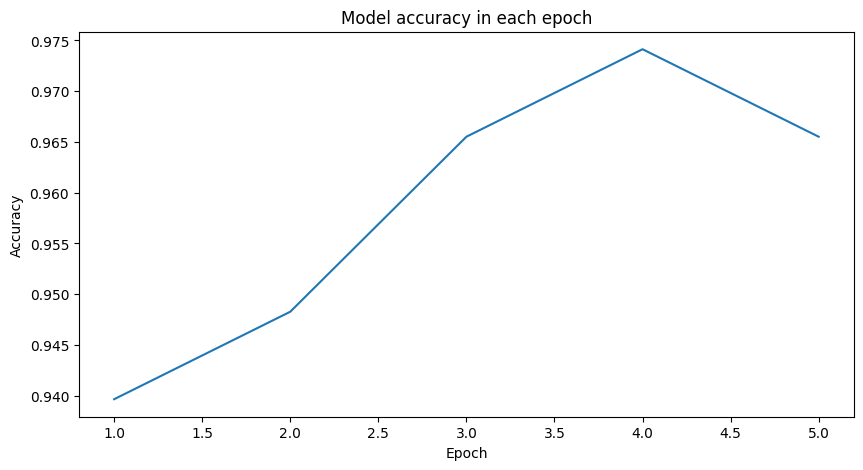

In [17]:
# Plot the accuracy in each epoch

# Create a figure
plt.figure(figsize=(10,5))

# Plot samples
sns.lineplot(data=results_df, x="epoch", y="accuracy")

# Set figure title and axes labels
plt.title("Model accuracy in each epoch")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")

# Show the plot
plt.show()

In [18]:
# Evaluate the final model
final_results = trainer.evaluate()
print(final_results)


/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):
/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '


{'eval_loss': 0.23770099878311157, 'eval_accuracy': 0.9655172413793104, 'eval_precision': 1.0, 'eval_recall': 0.9333333333333333, 'eval_f1': 0.9655172413793104, 'eval_runtime': 3.4081, 'eval_samples_per_second': 34.037, 'eval_steps_per_second': 2.347, 'epoch': 5.0}


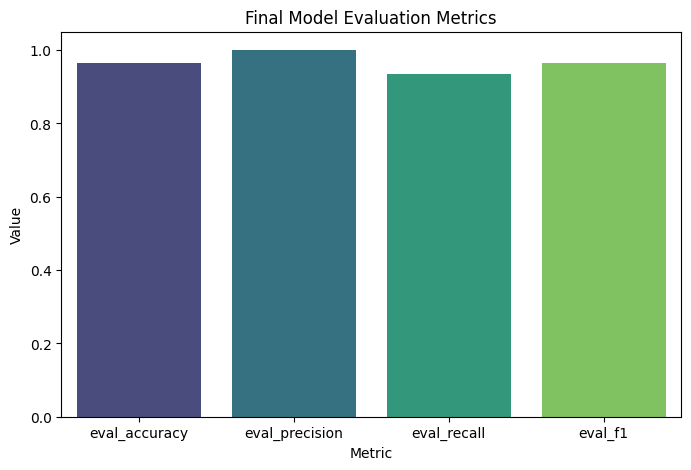

In [19]:
# Visualize final evaluation metrics
final_metrics = {key: final_results[key] for key in ['eval_accuracy', 'eval_precision', 'eval_recall', 'eval_f1']}
metrics_df = pd.DataFrame(final_metrics.items(), columns=["Metric", "Value"])

plt.figure(figsize=(8, 5))
sns.barplot(data=metrics_df, x="Metric", y="Value", palette="viridis")
plt.title("Final Model Evaluation Metrics")
plt.ylabel("Value")
plt.xlabel("Metric")
plt.show()


In [20]:
import os

# Set local model path
models_path = "./models/xlm_roberta"

# Create the directory if it doesn't exist
os.makedirs(models_path, exist_ok=True)
# Set local model path
models_path = "./models/xlm_roberta"
# Save the model and tokenizer for a later use 
model.save_pretrained(models_path)
tokenizer.save_pretrained(models_path)

('./models/xlm_roberta/tokenizer_config.json',
 './models/xlm_roberta/special_tokens_map.json',
 './models/xlm_roberta/sentencepiece.bpe.model',
 './models/xlm_roberta/added_tokens.json')

In [21]:
# Check model files saved locally
print("Saved Model Files:")
print(os.listdir(models_path))


Saved Model Files:
['tokenizer_config.json', 'model.safetensors', 'sentencepiece.bpe.model', 'special_tokens_map.json', 'config.json']


In [22]:

# Evaluate the final model
final_results = trainer.evaluate()
print(final_results)

/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):
/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '


{'eval_loss': 0.23770099878311157, 'eval_accuracy': 0.9655172413793104, 'eval_precision': 1.0, 'eval_recall': 0.9333333333333333, 'eval_f1': 0.9655172413793104, 'eval_runtime': 3.2881, 'eval_samples_per_second': 35.278, 'eval_steps_per_second': 2.433, 'epoch': 5.0}
